# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu") # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [5]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [6]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [7]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

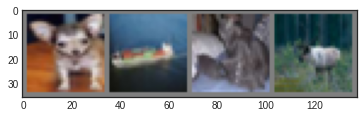

dog	 ship	 cat	 deer	


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [ ]:
''' 내가 짠 코드 아래 코드와 차이점이라면 maxpool2d를 나는 forward에서 정의했지만, 아래 코드는 __init__에서 정의하여 코드가 간결해졌고, 매 layer마다 maxpooling을 해주었다는 점이 차이.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, stride = 1, padding = 2)
        # in-channels = 3 <- RGB
        # out-channels =  필터 개수
        # kernel_size / filter-size = 3
        # stride = 1(default) -> s=1
        # padding = 2(default) -> p=2
        # input-data pixel size = 32*32
        # (n-f+2p)/s + 1 = new n
        # (32 - 5 + 2 x 2)/1 + 1 = 32 필터 한 번 거친 output의 size 32*32

        # maxpool2d : n = 32 -> 16

        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 2)
        # (16 - 5 + 2 x 2)/1 + 1 = 16

        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 4, stride = 1, padding = 1)
        # (15 - 4 + 2 x 1)/1 + 1 = 14

        self.conv4 = nn.Conv2d(in_channels = 16, out_channels = 7, kernel_size = 4, stride = 2, padding = 1)
        # (14 - 4 + 2 x 1)/2 + 1 = 7 

        self.fc1 = nn.Linear(7*7*7, 100)
        self.fc2 = nn.Linear(100, 10)
        
      
        # 10 : 10개의 category

    def forward(self, x):
        #print(x.size())
        x = F.relu(self.conv1(x))
        #print(x.size())
        x = F.max_pool2d(x, (2,2))
        #print(x.size())
        x = F.relu(self.conv2(x))
        #print(x.size())
        x = F.relu(self.conv3(x))
        #print(x.size())
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의
        #print(x.size())

        x = F.relu(self.fc1(x))
        #print(x.size())
        x = F.relu(self.fc2(x))
        #print(x.size(), '\n\n')
        
      

        return x
    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

net=Net()
'''

In [133]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        #out_channel 증가
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        #conv layer도 한 개 추가
        self.conv3 = nn.Conv2d(32, 64, 5)

        self.pool = nn.MaxPool2d(2, 2, 1)

        self.fc1 = nn.Linear(64 * 2 * 2, 192)
        #Full-connection layer도 추가
        self.fc2 = nn.Linear(192, 128)
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 10)
        self.dropout1 = nn.Dropout(p=0.5, inplace=False)
        #self.batchnorm1 = nn.BatchNorm2d(16)
        #self.batchnorm2 = nn.BatchNorm2d(32)
        #self.batchnorm3 = nn.BatchNorm2d(64)
       
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.batchnorm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        #x = self.batchnorm2(x)
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.batchnorm3(x)
        x = self.dropout1(x)
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [134]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [135]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [136]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [137]:
# 모델 구조 확인

summary(myNet, input_size=(3,32,32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 16, 28, 28]           1,216
         MaxPool2d-2            [4, 16, 15, 15]               0
            Conv2d-3            [4, 32, 11, 11]          12,832
         MaxPool2d-4              [4, 32, 6, 6]               0
            Conv2d-5              [4, 64, 2, 2]          51,264
         MaxPool2d-6              [4, 64, 2, 2]               0
           Dropout-7              [4, 64, 2, 2]               0
            Linear-8                   [4, 192]          49,344
           Dropout-9                   [4, 192]               0
           Linear-10                   [4, 128]          24,704
           Linear-11                    [4, 84]          10,836
           Linear-12                    [4, 10]             850
Total params: 151,046
Trainable params: 151,046
Non-trainable params: 0
-------------------------------

## 손실함수와 옵티마이저

In [138]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(),lr=0.001,momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [ ]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()                         # 가중치 초기화

        y_pred = myNet(inputs)                            # y_pred
        loss = criterion(y_pred, labels)                  # 손실함수를 이용해서 loss계산
        loss.backward()                               # back-propagation
        optimizer.step()                            # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 0.6757726304050011
Epoch: 1, Batch: 4000, Loss: 0.7041215839894794
Epoch: 1, Batch: 6000, Loss: 0.693835737761925
Epoch: 1, Batch: 8000, Loss: 0.6946941000592415
Epoch: 1, Batch: 10000, Loss: 0.7366043077785289
Epoch: 1, Batch: 12000, Loss: 0.7189286235486324
Epoch: 2, Batch: 2000, Loss: 0.6614811124024138
Epoch: 2, Batch: 4000, Loss: 0.7015722291360144
Epoch: 2, Batch: 6000, Loss: 0.6939417202052568
Epoch: 2, Batch: 8000, Loss: 0.7061927244741819
Epoch: 2, Batch: 10000, Loss: 0.7250841710610985
Epoch: 2, Batch: 12000, Loss: 0.7157864013206581
Epoch: 3, Batch: 2000, Loss: 0.6946102803699868
Epoch: 3, Batch: 4000, Loss: 0.7136885852933338
Epoch: 3, Batch: 6000, Loss: 0.6984653341885242
Epoch: 3, Batch: 8000, Loss: 0.7178002890252392
Epoch: 3, Batch: 10000, Loss: 0.6830384479228232
Epoch: 3, Batch: 12000, Loss: 0.7313047221679153
Epoch: 4, Batch: 2000, Loss: 0.7075441185281707
Epoch: 4, Batch: 4000, Loss: 0.6872783112560792
Epoch: 4, Batch: 6000, Loss: 0.6940

## 모델의 저장 및 로드

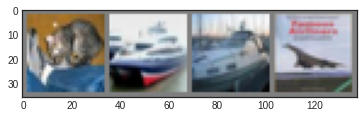

	cat 	ship 	ship 	plane
	cat 	dog 	plane 	horse


In [146]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4
print(' '.join('\t{}'.format(class_list[predicted[j]]) for j in range(4))) # batch-size = 4

In [147]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [148]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [149]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)      # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = Loaded_Net(images)                                  # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

68.97


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [150]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 68.6%
Accuracy of car: 80.9%
Accuracy of bird: 54.7%
Accuracy of cat: 48.1%
Accuracy of deer: 61.3%
Accuracy of dog: 58.7%
Accuracy of frog: 75.0%
Accuracy of horse: 76.3%
Accuracy of ship: 88.5%
Accuracy of truck: 77.8%
